# Calculating Standardized Precipitation Evapotranspiration Index (SPEI)

This notebook demonstrates how to calculate the Standardized Precipitation Evapotranspiration Index (SPEI) using the `precip-index` package.

**What is SPEI?**
- Extension of SPI that includes temperature/evapotranspiration
- Developed by Vicente-Serrano et al. (2010)
- Uses water balance (P - PET) instead of precipitation alone
- More sensitive to temperature changes and global warming
- Better for agricultural and ecological drought assessment

**Learning Objectives:**
1. Load real climate data (TerraClimate)
2. Choose between pre-computed PET or calculating from temperature
3. Compute SPEI with different input options
4. Compare SPI vs SPEI
5. Visualize and analyze SPEI results
6. Understand when to use SPEI vs SPI

## 1. Setup and Imports

In [1]:
# Add src directory to Python path
import sys
sys.path.insert(0, '../src')

# Core libraries
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from datetime import datetime
from pathlib import Path

# Import SPEI and SPI functions
from indices import (
    spi,
    spei, 
    spei_multi_scale,
    save_fitting_params,
    load_fitting_params,
    save_index_to_netcdf,
    classify_drought,
    get_drought_area_percentage
)

from utils import calculate_pet
from config import Periodicity

# Plotting settings
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

print("✓ All imports successful!")

✓ All imports successful!


## 2. User Configuration: Choose PET Input Method

**You have TWO options for SPEI calculation:**

### Option A: Use Pre-computed PET (Recommended if available)
- Faster computation
- Uses existing PET from TerraClimate or other sources
- Set `use_precomputed_pet = True`

### Option B: Calculate PET from Temperature
- Calculates PET using Thornthwaite method
- Requires temperature data
- Set `use_precomputed_pet = False`

**Choose your method below:**

In [19]:
# ========================================
# USER CONFIGURATION
# ========================================

# Choose PET input method
use_precomputed_pet = False  # Set to True to use pre-computed PET, False to calculate from temperature

# File paths
precip_file = '../input/terraclimate_bali_ppt_1958_2024.nc'
pet_file = '../input/terraclimate_bali_pet_1958_2024.nc'  # Only used if use_precomputed_pet=True
temp_file = '../input/terraclimate_bali_tmean_1958_2024.nc'  # Only used if use_precomputed_pet=False

# Variable names in your NetCDF files
precip_var = 'ppt'  # Precipitation variable name
pet_var = 'pet'     # PET variable name (if using pre-computed)
temp_var = 'tmean'   # Temperature variable name (if calculating PET)

# SPEI calculation parameters
calibration_start_year = 1991
calibration_end_year = 2020
data_start_year = 1958  # First year of your data

# Output directory
output_dir = Path('../output/netcdf')
output_dir.mkdir(parents=True, exist_ok=True)

print("Configuration:")
print(f"  PET method: {'Pre-computed' if use_precomputed_pet else 'Calculate from temperature'}")
print(f"  Calibration period: {calibration_start_year}-{calibration_end_year}")
print(f"  Output directory: {output_dir}")

Configuration:
  PET method: Calculate from temperature
  Calibration period: 1991-2020
  Output directory: ../output/netcdf


## 3. Load Climate Data

In [17]:
# Load precipitation data
print("Loading precipitation data...")
ds_precip = xr.open_dataset(precip_file)
precip = ds_precip[precip_var]

print("✓ Precipitation data loaded")
print(f"  Shape: {precip.shape}")
print(f"  Time range: {precip.time.min().values} to {precip.time.max().values}")
print(f"  Spatial extent: lat [{precip.lat.min().values:.2f}, {precip.lat.max().values:.2f}], lon [{precip.lon.min().values:.2f}, {precip.lon.max().values:.2f}]")
print(f"  Mean: {precip.mean().values:.1f} mm/month")
print(f"  Range: [{precip.min().values:.1f}, {precip.max().values:.1f}] mm/month")

Loading precipitation data...
✓ Precipitation data loaded
  Shape: (804, 24, 35)
  Time range: 1958-01-01T00:00:00.000000000 to 2024-12-01T00:00:00.000000000
  Spatial extent: lat [-8.94, -7.98], lon [114.35, 115.77]
  Mean: 158.6 mm/month
  Range: [0.0, 1004.7] mm/month


In [20]:
# Load PET data (Option A) or Temperature data (Option B)
if use_precomputed_pet:
    print("\nLoading pre-computed PET data...")
    ds_pet = xr.open_dataset(pet_file)
    pet = ds_pet[pet_var]
    
    print("✓ PET data loaded")
    print(f"  Shape: {pet.shape}")
    print(f"  Mean: {pet.mean().values:.1f} mm/month")
    print(f"  Range: [{pet.min().values:.1f}, {pet.max().values:.1f}] mm/month")
    
    # Verify dimensions match
    if not (pet.shape == precip.shape):
        raise ValueError(f"PET and precipitation dimensions don't match: {pet.shape} vs {precip.shape}")
    
    temperature = None  # Not needed for this option
    
else:
    print("\nLoading temperature data for PET calculation...")
    ds_temp = xr.open_dataset(temp_file)
    temperature = ds_temp[temp_var]
    
    print("✓ Temperature data loaded")
    print(f"  Shape: {temperature.shape}")
    print(f"  Mean: {temperature.mean().values:.1f} °C")
    print(f"  Range: [{temperature.min().values:.1f}, {temperature.max().values:.1f}] °C")
    
    # Verify dimensions match
    if not (temperature.shape == precip.shape):
        raise ValueError(f"Temperature and precipitation dimensions don't match: {temperature.shape} vs {precip.shape}")
    
    pet = None  # Will be calculated automatically


Loading temperature data for PET calculation...
✓ Temperature data loaded
  Shape: (804, 24, 35)
  Mean: 24.5 °C
  Range: [14.6, 29.9] °C


## 4. Visualize Climate Data

Let's examine the climate data at a sample location before calculating SPEI.

In [21]:
# Select a sample location (center of domain)
sample_lat_idx = len(precip.lat) // 2
sample_lon_idx = len(precip.lon) // 2
sample_lat = precip.lat[sample_lat_idx].values
sample_lon = precip.lon[sample_lon_idx].values

print(f"Sample location: lat={sample_lat:.3f}°, lon={sample_lon:.3f}°")

Sample location: lat=-8.479°, lon=115.062°


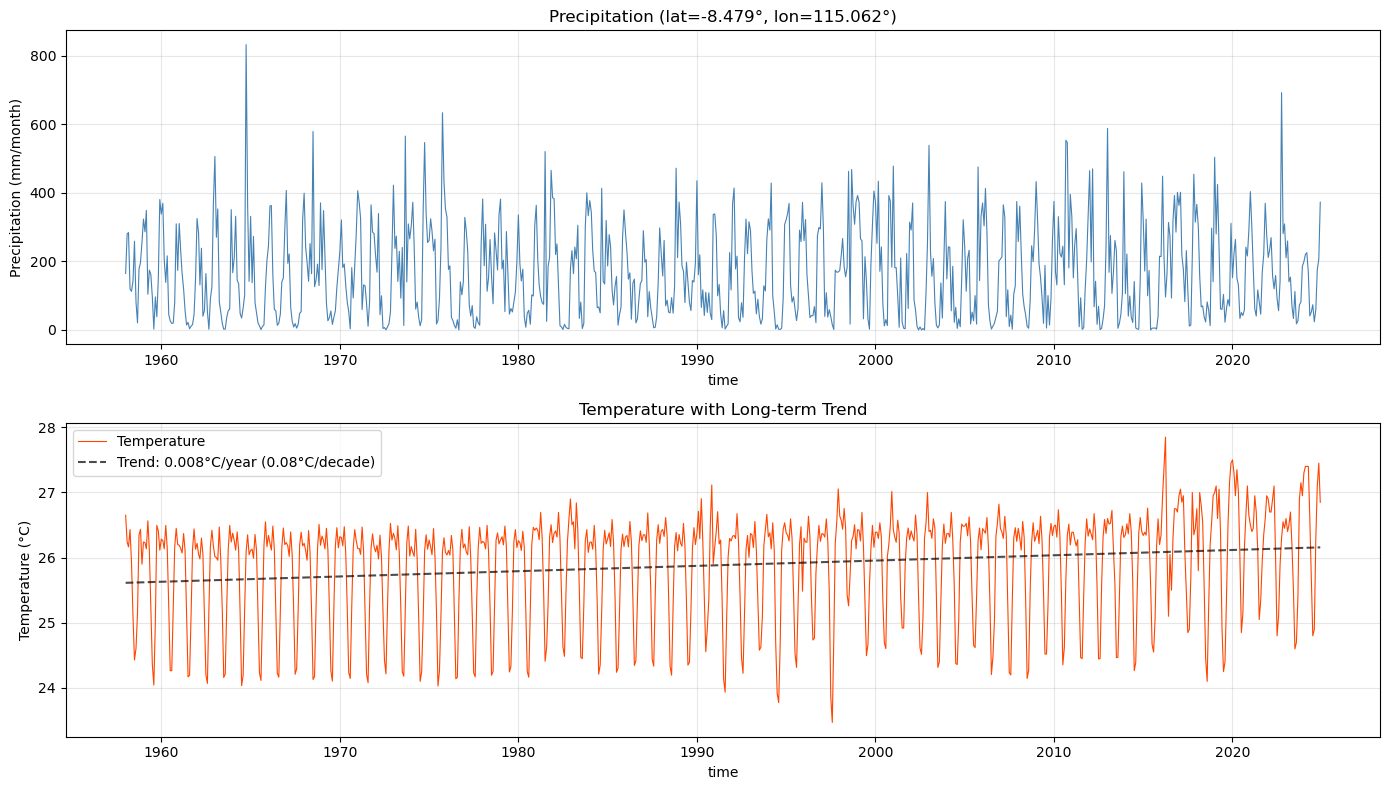


Temperature Statistics:
  Mean: 24.5 °C
  Range: [14.6, 29.9] °C


In [22]:
# Visualize precipitation and PET/Temperature
if use_precomputed_pet:
    # Show Precipitation and PET
    fig, axes = plt.subplots(3, 1, figsize=(14, 10))
    
    # Precipitation
    precip[:, sample_lat_idx, sample_lon_idx].plot(ax=axes[0], linewidth=0.8, color='steelblue')
    axes[0].set_title(f'Precipitation (lat={sample_lat:.3f}°, lon={sample_lon:.3f}°)')
    axes[0].set_ylabel('Precipitation (mm/month)')
    axes[0].grid(True, alpha=0.3)
    
    # PET
    pet[:, sample_lat_idx, sample_lon_idx].plot(ax=axes[1], linewidth=0.8, color='orangered')
    axes[1].set_title('Potential Evapotranspiration (PET)')
    axes[1].set_ylabel('PET (mm/month)')
    axes[1].grid(True, alpha=0.3)
    
    # Water Balance (P - PET)
    water_balance = precip - pet
    wb = water_balance[:, sample_lat_idx, sample_lon_idx]
    wb.plot(ax=axes[2], linewidth=0.8, color='darkgreen')
    axes[2].axhline(y=0, color='k', linestyle='-', linewidth=0.8, alpha=0.3)
    axes[2].fill_between(wb.time, 0, wb, where=(wb >= 0), alpha=0.3, color='blue', label='Surplus')
    axes[2].fill_between(wb.time, 0, wb, where=(wb < 0), alpha=0.3, color='red', label='Deficit')
    axes[2].set_title('Water Balance (P - PET)')
    axes[2].set_ylabel('P - PET (mm/month)')
    axes[2].grid(True, alpha=0.3)
    axes[2].legend()
    
    plt.tight_layout()
    plt.show()
    
    # Statistics
    print(f"\nWater Balance Statistics:")
    print(f"  Mean P: {precip.mean().values:.1f} mm/month")
    print(f"  Mean PET: {pet.mean().values:.1f} mm/month")
    print(f"  Mean (P-PET): {water_balance.mean().values:.1f} mm/month")
    print(f"  Deficit months: {(water_balance < 0).sum().values} ({100*(water_balance < 0).sum()/water_balance.size:.1f}%)")

else:
    # Show Precipitation and Temperature
    fig, axes = plt.subplots(2, 1, figsize=(14, 8))
    
    # Precipitation
    precip[:, sample_lat_idx, sample_lon_idx].plot(ax=axes[0], linewidth=0.8, color='steelblue')
    axes[0].set_title(f'Precipitation (lat={sample_lat:.3f}°, lon={sample_lon:.3f}°)')
    axes[0].set_ylabel('Precipitation (mm/month)')
    axes[0].grid(True, alpha=0.3)
    
    # Temperature with trend
    temp_series = temperature[:, sample_lat_idx, sample_lon_idx]
    temp_series.plot(ax=axes[1], linewidth=0.8, color='orangered', label='Temperature')
    
    # Add trend line
    x = np.arange(len(temp_series))
    valid_mask = ~np.isnan(temp_series.values)
    if valid_mask.sum() > 0:
        z = np.polyfit(x[valid_mask], temp_series.values[valid_mask], 1)
        p = np.poly1d(z)
        axes[1].plot(temp_series.time, p(x), 'k--', linewidth=1.5, alpha=0.7, 
                    label=f'Trend: {z[0]*12:.3f}°C/year ({z[0]*120:.2f}°C/decade)')
    
    axes[1].set_title('Temperature with Long-term Trend')
    axes[1].set_ylabel('Temperature (°C)')
    axes[1].grid(True, alpha=0.3)
    axes[1].legend()
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nTemperature Statistics:")
    print(f"  Mean: {temperature.mean().values:.1f} °C")
    print(f"  Range: [{temperature.min().values:.1f}, {temperature.max().values:.1f}] °C")

## 5. Calculate SPEI

Now we'll calculate SPEI-12 using the method you chose above.

In [23]:
print("Calculating SPEI-12...")
print(f"  Method: {'Using pre-computed PET' if use_precomputed_pet else 'Calculating PET from temperature'}")

if use_precomputed_pet:
    # Option A: Use pre-computed PET
    spei_12, params = spei(
        precip=precip,
        pet=pet,
        scale=12,
        periodicity='monthly',
        calibration_start_year=calibration_start_year,
        calibration_end_year=calibration_end_year,
        return_params=True
    )
else:
    # Option B: Calculate PET from temperature
    spei_12, params = spei(
        precip=precip,
        temperature=temperature,
        latitude=precip.lat.values,
        scale=12,
        periodicity='monthly',
        calibration_start_year=calibration_start_year,
        calibration_end_year=calibration_end_year,
        return_params=True
    )

print("✓ SPEI-12 calculation complete!")
print(f"  Output shape: {spei_12.shape}")
print(f"  Valid range: [{float(np.nanmin(spei_12.values)):.2f}, {float(np.nanmax(spei_12.values)):.2f}]")
print(f"  Mean: {float(np.nanmean(spei_12.values)):.3f}")
print(f"  Std: {float(np.nanstd(spei_12.values)):.3f}")

2026-01-24 19:56:32 | INFO     | indices | Computing SPEI-12
2026-01-24 19:56:32 | INFO     | indices | Computing PET from temperature using Thornthwaite method
2026-01-24 19:56:32 | INFO     | utils | Calculating PET from xarray DataArray


Calculating SPEI-12...
  Method: Calculating PET from temperature


2026-01-24 19:56:33 | INFO     | indices | Input shape: (804, 24, 35), data_start_year: 1958
2026-01-24 19:56:33 | INFO     | compute | Computing index: shape=(804, 24, 35), scale=12, grid_cells=840
2026-01-24 19:56:33 | INFO     | compute | Step 1/3: Applying temporal scaling...
2026-01-24 19:56:33 | INFO     | compute | Step 2/3: Computing gamma parameters...
2026-01-24 19:56:33 | INFO     | compute | Step 3/3: Transforming to standard normal...
2026-01-24 19:56:33 | INFO     | compute | Index computation complete
2026-01-24 19:56:33 | INFO     | indices | SPEI-12 computation complete. Output shape: (804, 24, 35)


✓ SPEI-12 calculation complete!
  Output shape: (804, 24, 35)
  Valid range: [-2.68, 2.92]
  Mean: -0.029
  Std: 0.990


## 6. Compare SPI vs SPEI

Let's calculate SPI-12 and compare with SPEI-12 to see the effect of including temperature/PET.

In [24]:
print("Calculating SPI-12 for comparison...")

spi_12 = spi(
    precip=precip,
    scale=12,
    periodicity='monthly',
    calibration_start_year=calibration_start_year,
    calibration_end_year=calibration_end_year
)

print("✓ SPI-12 calculation complete!")

2026-01-24 19:56:37 | INFO     | indices | Computing SPI-12
2026-01-24 19:56:37 | INFO     | indices | Input shape: (804, 24, 35), dims: ('time', 'lat', 'lon'), data_start_year: 1958
2026-01-24 19:56:37 | INFO     | compute | Computing index: shape=(804, 24, 35), scale=12, grid_cells=840
2026-01-24 19:56:37 | INFO     | compute | Step 1/3: Applying temporal scaling...
2026-01-24 19:56:37 | INFO     | compute | Step 2/3: Computing gamma parameters...
2026-01-24 19:56:37 | INFO     | compute | Step 3/3: Transforming to standard normal...


Calculating SPI-12 for comparison...


2026-01-24 19:56:37 | INFO     | compute | Index computation complete
2026-01-24 19:56:37 | INFO     | indices | SPI-12 computation complete. Output shape: (804, 24, 35)


✓ SPI-12 calculation complete!


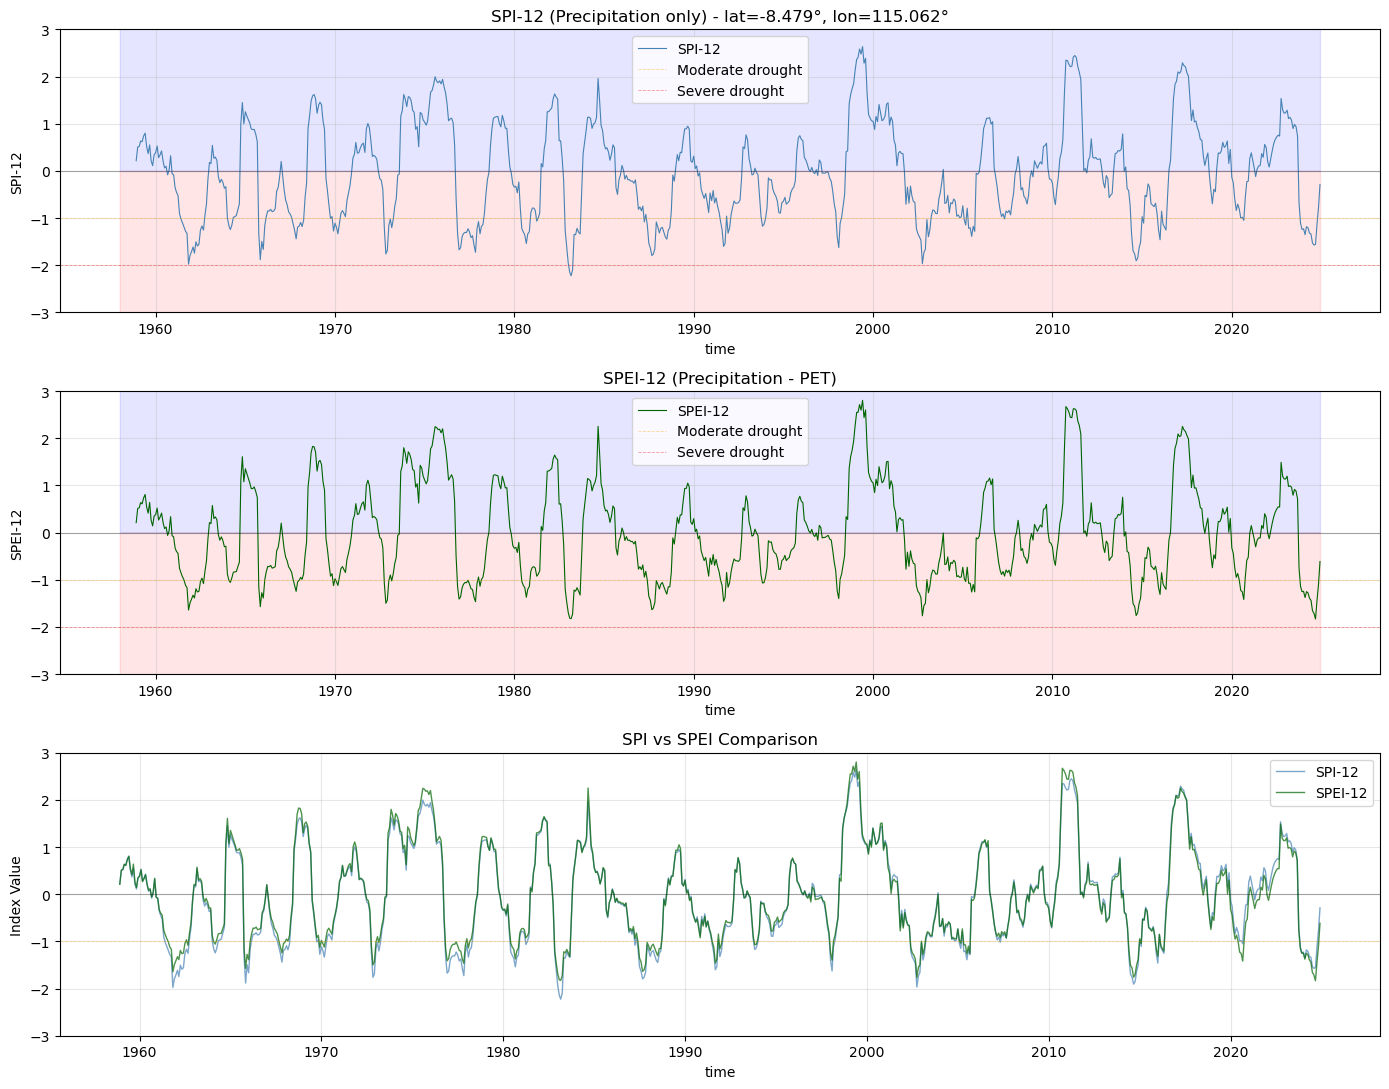


Correlation between SPI and SPEI: 0.994

Drought months (index ≤ -1.0):
  SPI-12: 155 months (19.3%)
  SPEI-12: 134 months (16.7%)
  Difference: -21 months (-2.6%)


In [25]:
# Compare SPI and SPEI at sample location
fig, axes = plt.subplots(3, 1, figsize=(14, 11))

# SPI
spi_series = spi_12[:, sample_lat_idx, sample_lon_idx]
spi_series.plot(ax=axes[0], linewidth=0.8, color='steelblue', label='SPI-12')
axes[0].axhline(y=0, color='k', linestyle='-', linewidth=0.8, alpha=0.3)
axes[0].axhline(y=-1.0, color='orange', linestyle='--', linewidth=0.6, alpha=0.4, label='Moderate drought')
axes[0].axhline(y=-2.0, color='red', linestyle='--', linewidth=0.6, alpha=0.4, label='Severe drought')
axes[0].fill_between(spi_series.time, -10, 0, alpha=0.1, color='red')
axes[0].fill_between(spi_series.time, 0, 10, alpha=0.1, color='blue')
axes[0].set_title(f'SPI-12 (Precipitation only) - lat={sample_lat:.3f}°, lon={sample_lon:.3f}°')
axes[0].set_ylabel('SPI-12')
axes[0].set_ylim(-3, 3)
axes[0].grid(True, alpha=0.3)
axes[0].legend()

# SPEI
spei_series = spei_12[:, sample_lat_idx, sample_lon_idx]
spei_series.plot(ax=axes[1], linewidth=0.8, color='darkgreen', label='SPEI-12')
axes[1].axhline(y=0, color='k', linestyle='-', linewidth=0.8, alpha=0.3)
axes[1].axhline(y=-1.0, color='orange', linestyle='--', linewidth=0.6, alpha=0.4, label='Moderate drought')
axes[1].axhline(y=-2.0, color='red', linestyle='--', linewidth=0.6, alpha=0.4, label='Severe drought')
axes[1].fill_between(spei_series.time, -10, 0, alpha=0.1, color='red')
axes[1].fill_between(spei_series.time, 0, 10, alpha=0.1, color='blue')
axes[1].set_title('SPEI-12 (Precipitation - PET)')
axes[1].set_ylabel('SPEI-12')
axes[1].set_ylim(-3, 3)
axes[1].grid(True, alpha=0.3)
axes[1].legend()

# Comparison (both on same plot)
spi_series.plot(ax=axes[2], linewidth=1.0, color='steelblue', label='SPI-12', alpha=0.7)
spei_series.plot(ax=axes[2], linewidth=1.0, color='darkgreen', label='SPEI-12', alpha=0.7)
axes[2].axhline(y=0, color='k', linestyle='-', linewidth=0.8, alpha=0.3)
axes[2].axhline(y=-1.0, color='orange', linestyle='--', linewidth=0.6, alpha=0.4)
axes[2].set_title('SPI vs SPEI Comparison')
axes[2].set_ylabel('Index Value')
axes[2].set_ylim(-3, 3)
axes[2].grid(True, alpha=0.3)
axes[2].legend()

plt.tight_layout()
plt.show()

# Calculate statistics
valid_mask = ~(np.isnan(spi_series.values) | np.isnan(spei_series.values))
if valid_mask.sum() > 0:
    correlation = np.corrcoef(spi_series.values[valid_mask], spei_series.values[valid_mask])[0, 1]
    print(f"\nCorrelation between SPI and SPEI: {correlation:.3f}")

# Count drought months
spi_drought = (spi_series <= -1.0).sum().values
spei_drought = (spei_series <= -1.0).sum().values
total_months = len(spi_series)

print(f"\nDrought months (index ≤ -1.0):")
print(f"  SPI-12: {spi_drought} months ({100*spi_drought/total_months:.1f}%)")
print(f"  SPEI-12: {spei_drought} months ({100*spei_drought/total_months:.1f}%)")
print(f"  Difference: {int(spei_drought - spi_drought)} months ({100*(spei_drought - spi_drought)/total_months:.1f}%)")

### Key Differences: SPI vs SPEI

**SPI (Precipitation only):**
- ✓ Simple, requires only precipitation data
- ✓ Good for meteorological drought
- ✗ Doesn't account for temperature/evaporation
- ✗ May miss agricultural drought in warming climates

**SPEI (Precipitation - PET):**
- ✓ Accounts for temperature and evaporation
- ✓ Better for agricultural and ecological drought
- ✓ More sensitive to climate change
- ✗ Requires temperature data or PET
- ✗ Slightly more complex calculation

**When to use SPEI:**
- Agricultural applications (crop monitoring)
- Vegetation/ecosystem monitoring
- Climate change impact studies
- Regions with significant temperature trends
- Forest fire risk assessment

## 7. Multi-Scale SPEI Analysis

In [26]:
print("Calculating SPEI for scales: 1, 3, 6, 12 months...")

if use_precomputed_pet:
    spei_multi = spei_multi_scale(
        precip=precip,
        pet=pet,
        scales=[1, 3, 6, 12],
        periodicity='monthly',
        calibration_start_year=calibration_start_year,
        calibration_end_year=calibration_end_year
    )
else:
    spei_multi = spei_multi_scale(
        precip=precip,
        temperature=temperature,
        latitude=precip.lat.values,
        scales=[1, 3, 6, 12],
        periodicity='monthly',
        calibration_start_year=calibration_start_year,
        calibration_end_year=calibration_end_year
    )

print("✓ Multi-scale SPEI calculation complete!")
print(f"  Variables: {list(spei_multi.data_vars)}")

2026-01-24 19:56:58 | INFO     | indices | Computing SPEI for scales: [1, 3, 6, 12]
2026-01-24 19:56:58 | INFO     | indices | Processing scale 1...
2026-01-24 19:56:58 | INFO     | indices | Computing SPEI-1
2026-01-24 19:56:58 | INFO     | indices | Computing PET from temperature using Thornthwaite method
2026-01-24 19:56:58 | INFO     | utils | Calculating PET from xarray DataArray


Calculating SPEI for scales: 1, 3, 6, 12 months...


2026-01-24 19:56:59 | INFO     | indices | Input shape: (804, 24, 35), data_start_year: 1958
2026-01-24 19:56:59 | INFO     | compute | Computing index: shape=(804, 24, 35), scale=1, grid_cells=840
2026-01-24 19:56:59 | INFO     | compute | Step 1/3: Applying temporal scaling...
2026-01-24 19:56:59 | INFO     | compute | Step 2/3: Computing gamma parameters...
2026-01-24 19:56:59 | INFO     | compute | Step 3/3: Transforming to standard normal...
2026-01-24 19:56:59 | INFO     | compute | Index computation complete
2026-01-24 19:56:59 | INFO     | indices | SPEI-1 computation complete. Output shape: (804, 24, 35)
2026-01-24 19:56:59 | INFO     | indices | Processing scale 3...
2026-01-24 19:56:59 | INFO     | indices | Computing SPEI-3
2026-01-24 19:56:59 | INFO     | indices | Computing PET from temperature using Thornthwaite method
2026-01-24 19:56:59 | INFO     | utils | Calculating PET from xarray DataArray
2026-01-24 19:56:59 | INFO     | indices | Input shape: (804, 24, 35), data

✓ Multi-scale SPEI calculation complete!
  Variables: ['spei_gamma_1_month', 'spei_gamma_3_month', 'spei_gamma_6_month', 'spei_gamma_12_month']


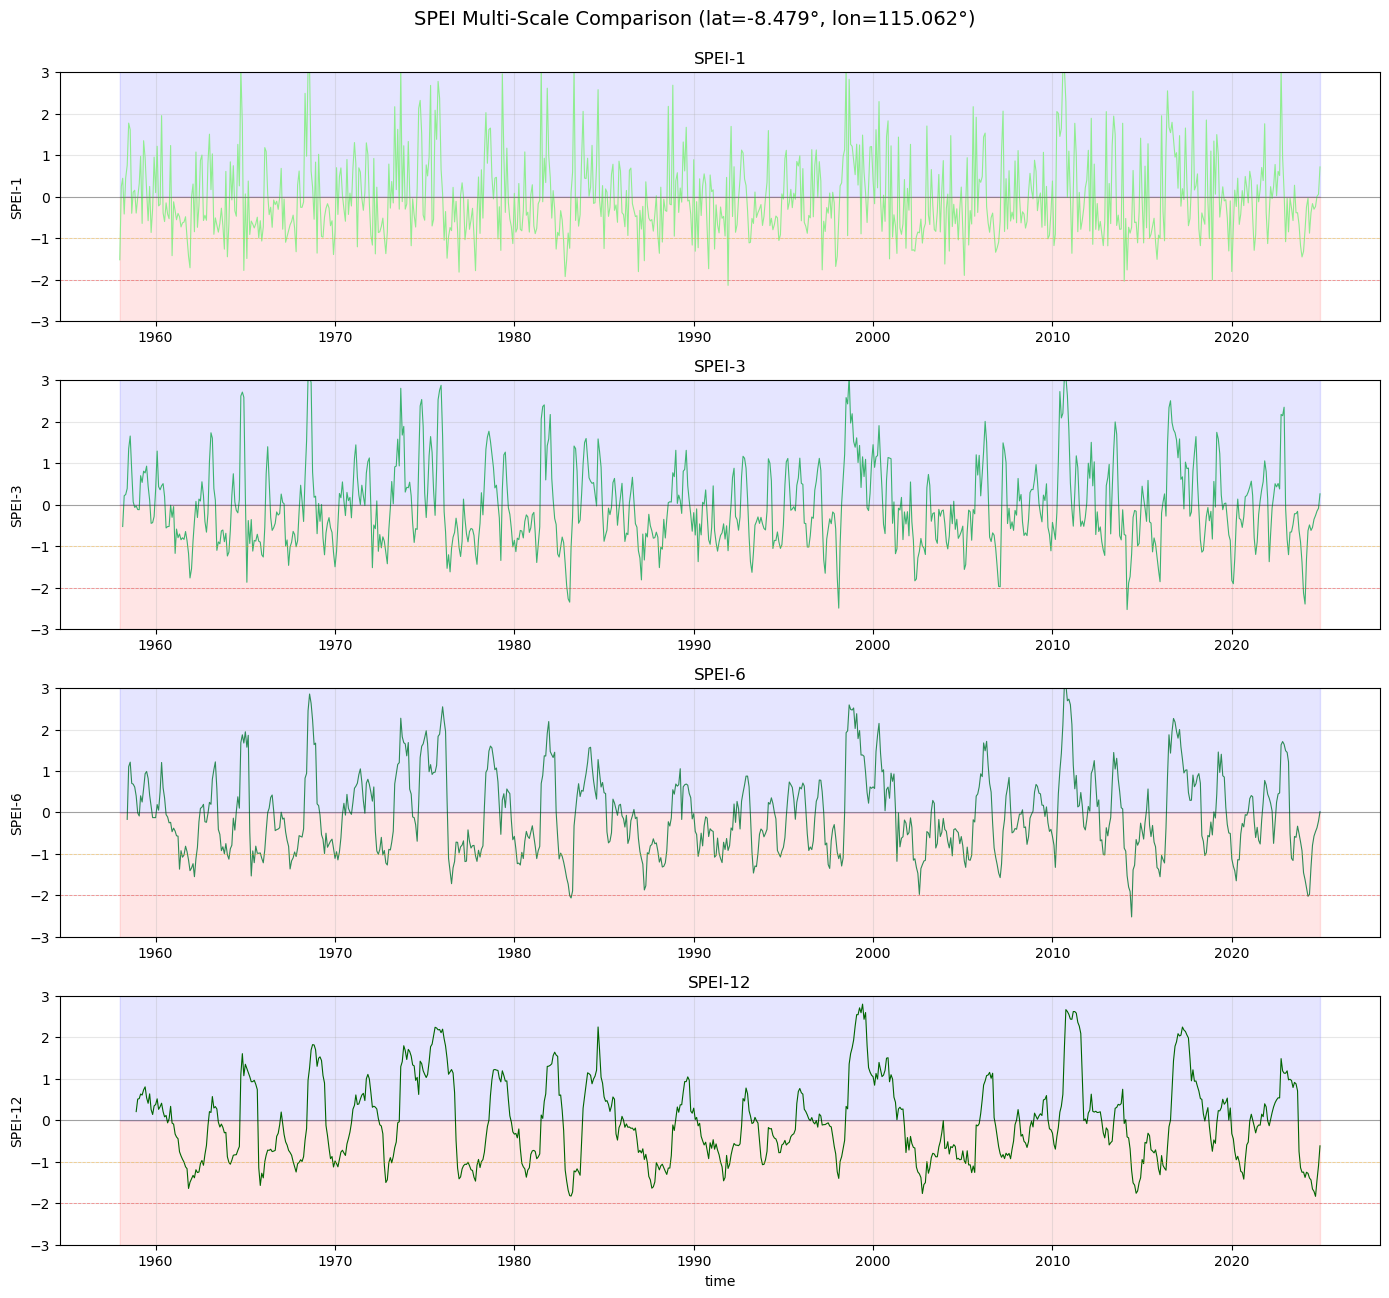

In [27]:
# Compare different SPEI time scales
fig, axes = plt.subplots(4, 1, figsize=(14, 13))

scales = [1, 3, 6, 12]
colors = ['lightgreen', 'mediumseagreen', 'seagreen', 'darkgreen']

for i, (scale, color) in enumerate(zip(scales, colors)):
    var_name = f'spei_gamma_{scale}_month'
    spei_data = spei_multi[var_name]
    
    spei_data[:, sample_lat_idx, sample_lon_idx].plot(
        ax=axes[i], 
        linewidth=0.8, 
        color=color
    )
    
    axes[i].axhline(y=0, color='k', linestyle='-', linewidth=0.8, alpha=0.3)
    axes[i].axhline(y=-1.0, color='orange', linestyle='--', linewidth=0.6, alpha=0.4)
    axes[i].axhline(y=-2.0, color='red', linestyle='--', linewidth=0.6, alpha=0.4)
    axes[i].fill_between(spei_data.time, -10, 0, alpha=0.1, color='red')
    axes[i].fill_between(spei_data.time, 0, 10, alpha=0.1, color='blue')
    
    axes[i].set_title(f'SPEI-{scale}')
    axes[i].set_ylabel(f'SPEI-{scale}')
    axes[i].set_ylim(-3, 3)
    axes[i].grid(True, alpha=0.3)
    
    if i < 3:
        axes[i].set_xlabel('')

plt.suptitle(f'SPEI Multi-Scale Comparison (lat={sample_lat:.3f}°, lon={sample_lon:.3f}°)', 
             fontsize=14, y=0.995)
plt.tight_layout()
plt.show()

## 8. Spatial Analysis

Visualize SPEI-12 spatial patterns across Bali at different time periods.

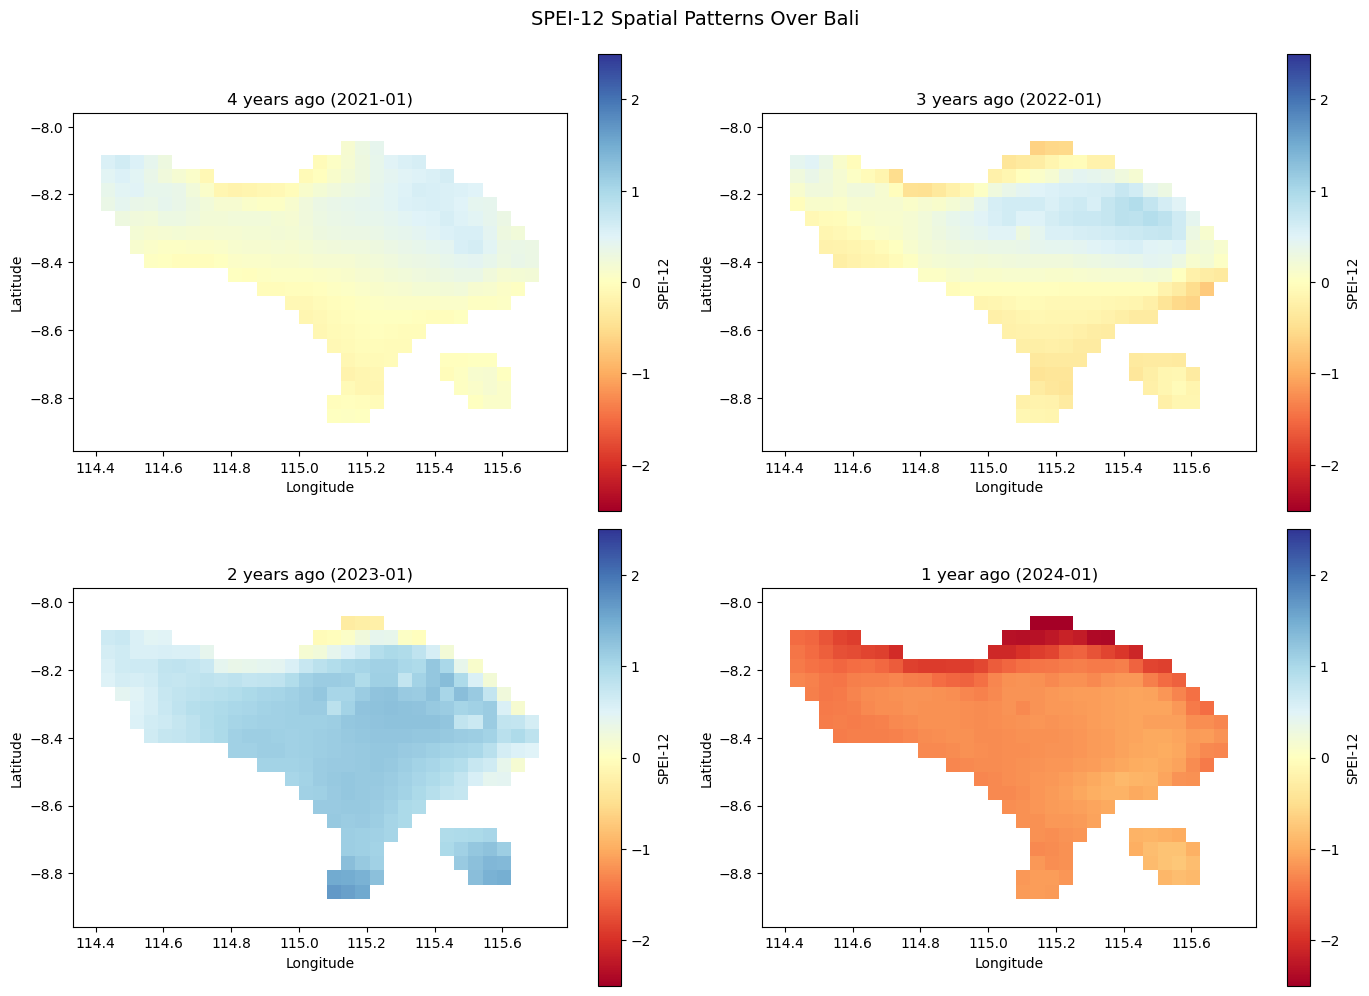

In [28]:
# Create spatial maps for recent years
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

# Select recent time points
time_indices = [-48, -36, -24, -12]  # 4, 3, 2, 1 years ago
titles = ['4 years ago', '3 years ago', '2 years ago', '1 year ago']

for i, (t_idx, title) in enumerate(zip(time_indices, titles)):
    time_str = str(spei_12.time[t_idx].values)[:7]  # Format: YYYY-MM
    
    im = axes[i].pcolormesh(
        spei_12.lon,
        spei_12.lat,
        spei_12[t_idx, :, :],
        cmap='RdYlBu',
        vmin=-2.5,
        vmax=2.5,
        shading='auto'
    )
    axes[i].set_title(f'{title} ({time_str})')
    axes[i].set_xlabel('Longitude')
    axes[i].set_ylabel('Latitude')
    axes[i].set_aspect('equal')
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=axes[i])
    cbar.set_label('SPEI-12')

plt.suptitle('SPEI-12 Spatial Patterns Over Bali', fontsize=14, y=0.995)
plt.tight_layout()
plt.show()

## 9. Drought Area Percentage Analysis

In [29]:
# Calculate drought area for both SPI and SPEI
print("Calculating drought area percentages...")

spi_drought_area = get_drought_area_percentage(spi_12, threshold=-1.0)
spei_drought_area = get_drought_area_percentage(spei_12, threshold=-1.0)

print("✓ Drought area calculation complete!")

Calculating drought area percentages...
✓ Drought area calculation complete!


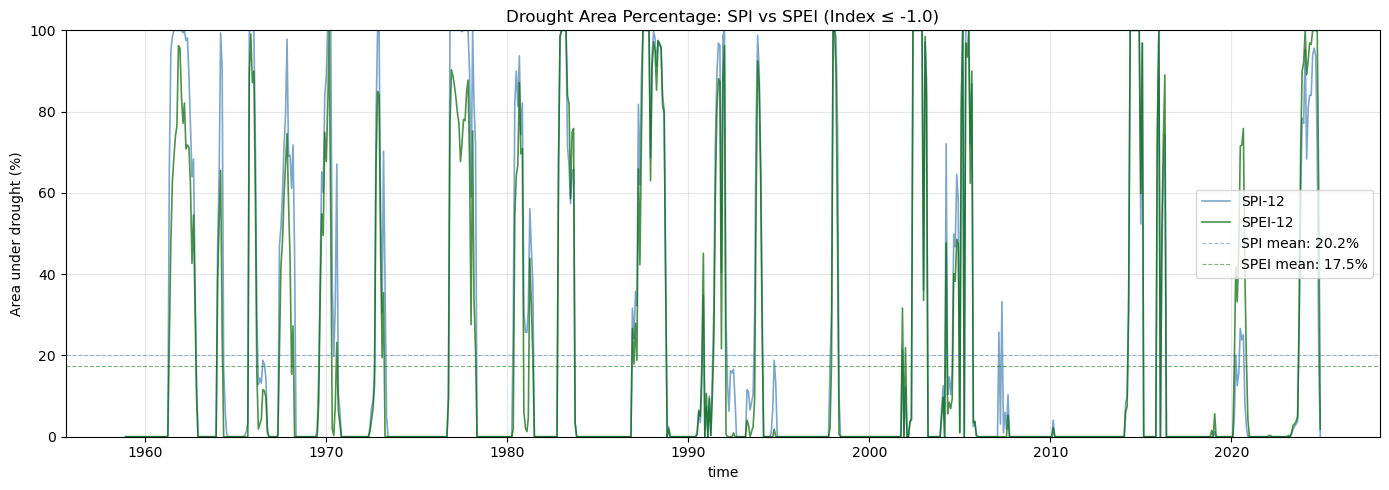


Drought Area Statistics:
  SPI-12 mean: 20.2%
  SPEI-12 mean: 17.5%
  Difference: -2.7%


In [30]:
# Plot comparison
fig, ax = plt.subplots(figsize=(14, 5))

spi_drought_area.plot(ax=ax, linewidth=1.2, color='steelblue', label='SPI-12', alpha=0.7)
spei_drought_area.plot(ax=ax, linewidth=1.2, color='darkgreen', label='SPEI-12', alpha=0.7)

spi_mean = float(spi_drought_area.mean())
spei_mean = float(spei_drought_area.mean())

ax.axhline(y=spi_mean, color='steelblue', linestyle='--', 
           linewidth=0.8, alpha=0.5, label=f'SPI mean: {spi_mean:.1f}%')
ax.axhline(y=spei_mean, color='darkgreen', linestyle='--', 
           linewidth=0.8, alpha=0.5, label=f'SPEI mean: {spei_mean:.1f}%')

ax.set_title('Drought Area Percentage: SPI vs SPEI (Index ≤ -1.0)', fontsize=12)
ax.set_ylabel('Area under drought (%)')
ax.set_ylim(0, 100)
ax.grid(True, alpha=0.3)
ax.legend()

plt.tight_layout()
plt.show()

print(f"\nDrought Area Statistics:")
print(f"  SPI-12 mean: {spi_mean:.1f}%")
print(f"  SPEI-12 mean: {spei_mean:.1f}%")
print(f"  Difference: {(spei_mean - spi_mean):.1f}%")

## 10. Save Results

In [31]:
# Save SPEI results
spei_12_file = output_dir / 'spei_12_bali.nc'
save_index_to_netcdf(spei_12, str(spei_12_file), compress=True, complevel=5)
print(f"✓ SPEI-12 saved to: {spei_12_file}")

# Save multi-scale SPEI
spei_multi_file = output_dir / 'spei_multi_scale_bali.nc'
save_index_to_netcdf(spei_multi, str(spei_multi_file), compress=True, complevel=5)
print(f"✓ Multi-scale SPEI saved to: {spei_multi_file}")

# Save fitting parameters for future reuse
params_file = output_dir / 'spei_gamma_params_12_month_bali.nc'
save_fitting_params(
    params,
    str(params_file),
    scale=12,
    periodicity='monthly',
    index_type='spei',
    calibration_start_year=calibration_start_year,
    calibration_end_year=calibration_end_year,
    coords={'lat': precip.lat, 'lon': precip.lon}
)
print(f"✓ SPEI parameters saved to: {params_file}")

# If PET was calculated from temperature, save it for future use
if not use_precomputed_pet:
    pet_file_out = output_dir / 'pet_thornthwaite_bali.nc'
    # PET was calculated internally, need to recalculate to save
    pet_calculated = calculate_pet(temperature, precip.lat.values, data_start_year)
    pet_calculated.to_netcdf(str(pet_file_out))
    print(f"✓ Calculated PET saved to: {pet_file_out}")

print("\n✓ All results saved successfully!")

2026-01-24 19:57:32 | INFO     | indices | Saving to: ../output/netcdf/spei_12_bali.nc
2026-01-24 19:57:32 | INFO     | indices | Saved: ../output/netcdf/spei_12_bali.nc
2026-01-24 19:57:32 | INFO     | indices | Saving to: ../output/netcdf/spei_multi_scale_bali.nc


✓ SPEI-12 saved to: ../output/netcdf/spei_12_bali.nc


2026-01-24 19:57:32 | INFO     | indices | Saved: ../output/netcdf/spei_multi_scale_bali.nc
2026-01-24 19:57:32 | INFO     | indices | Saving fitting parameters to: ../output/netcdf/spei_gamma_params_12_month_bali.nc
2026-01-24 19:57:33 | INFO     | indices | Fitting parameters saved: ../output/netcdf/spei_gamma_params_12_month_bali.nc
2026-01-24 19:57:33 | INFO     | utils | Calculating PET from xarray DataArray


✓ Multi-scale SPEI saved to: ../output/netcdf/spei_multi_scale_bali.nc
✓ SPEI parameters saved to: ../output/netcdf/spei_gamma_params_12_month_bali.nc
✓ Calculated PET saved to: ../output/netcdf/pet_thornthwaite_bali.nc

✓ All results saved successfully!


## 11. Summary and Next Steps

### What We Did:

1. ✅ Loaded real TerraClimate data for Bali (1958-2024)
2. ✅ Calculated SPEI using either:
   - Pre-computed PET (faster, uses TerraClimate PET), or
   - Calculated PET from temperature (Thornthwaite method)
3. ✅ Compared SPI vs SPEI to see temperature effects
4. ✅ Analyzed multiple SPEI time scales (1, 3, 6, 12 months)
5. ✅ Created spatial maps of drought conditions
6. ✅ Calculated drought area percentage trends
7. ✅ Saved all results for future analysis

### Key Findings:

- **SPI vs SPEI Correlation:** Shows how similar/different the indices are
- **Drought Frequency:** SPEI typically identifies more agricultural drought
- **Spatial Patterns:** Drought distribution varies across Bali
- **Temporal Trends:** Long-term changes in drought characteristics

### Recommended Applications:

- 🌾 **Agricultural Monitoring:** Use SPEI-3 or SPEI-6 for crop drought
- 🌳 **Forest Fire Risk:** Use SPEI-6 or SPEI-12 for vegetation stress
- 💧 **Water Resources:** Use SPEI-12 or longer for reservoir management
- 📊 **Climate Studies:** Compare SPI vs SPEI trends over time

### Next Steps:

1. **Event Analysis:** Use notebook `03_event_characteristics.ipynb` to:
   - Identify specific drought events
   - Calculate event duration, magnitude, intensity
   - Analyze drought evolution over time

2. **Visualization:** Use notebook `04_visualization_gallery.ipynb` for:
   - Professional drought maps
   - Time series plots with WMO colors
   - Spatial statistics visualization

3. **Advanced Analysis:**
   - Calculate SPEI for different regions
   - Analyze seasonal patterns
   - Compare different calibration periods
   - Validate against crop yield or other impact data

### Using Your Own Data:

To use this notebook with your own data:

1. Modify the configuration in **Section 2**:
   - Set `precip_file`, `pet_file`, or `temp_file` paths
   - Update variable names (`precip_var`, `pet_var`, `temp_var`)
   - Adjust calibration period and data start year

2. Choose PET method:
   - `use_precomputed_pet = True` if you have PET data
   - `use_precomputed_pet = False` to calculate from temperature

3. Run all cells!

### Learn More:

- 📖 [SPEI Guide](../docs/user-guide/spei.md) - Detailed methodology
- 📖 [Run Theory Guide](../docs/user-guide/runtheory.md) - Event analysis framework
- 📖 [Visualization Guide](../docs/user-guide/visualization.md) - Plotting options
- 📄 Vicente-Serrano et al. (2010) - Original SPEI paper

---

**Version:** 2026.1  
**Last Updated:** 2026-01-23